In [26]:
import tensorflow as tf
tf.__version__
tf.config.experimental.enable_op_determinism()
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
  tf.config.experimental.set_memory_growth(gpu, True)

In [27]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
import matplotlib.pyplot as plt
import random

In [28]:
def plot_columns(df):
    colors = plt.cm.tab20(range(df.shape[1]))  

    for i, column in enumerate(df.columns):
        color = colors[i % 24]

        plt.figure()
        plt.plot(df.index, df[column], color=color)
        plt.xlabel('Tempo')
        plt.ylabel('Valor')
        plt.title(column)

    plt.show()

In [29]:
def plot_correlation_matrix(df):
    correlation_matrix = df.corr()
    plt.figure(figsize=(10, 8))
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
    plt.title("Correlation Matrix Heatmap")
    plt.show()

In [30]:
tf.keras.backend.clear_session()

In [31]:
subject = 'Rio Grande Do Norte - Consumo de Cimento (t)'
start_index = 0
split_index = 179
window_size = 36
train_split = split_index + 1 - 12

In [32]:
data = pd.read_csv('2003_mo_model_input_RN.csv')
pd.set_option('display.max_columns', None)
data

,Unnamed: 0,Rio Grande Do Norte - Consumo de Cimento (t),Rio Grande do Norte - IDH,IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),Taxa Selic (%),IGP-DI,População,Estoque liquido de capital fixo - (R$),INCC (%),Rio Grande Do Norte - Produção de Cimento (t),Rio Grande do Norte - PIB - Estadual,Rio Grande do Norte - PIB - Construção Civil,Rio Grande do Norte - PIB - Per Capita,Rio Grande do Norte - PIB - Preços de Mercado,Rio Grande do Norte - Desemprego
0,2003-1,36.825,0.689488,0.724032,-5331.049150,11.520143,1.639718,1.036534,1.772069e+08,7.330309e+06,0.969649,27.698760,3.164847e+07,1.998664e+06,9.097985,2.879532e+07,8.294170
1,2003-2,34.088,0.689892,0.690297,-5318.079644,11.189862,1.378899,0.993449,1.773884e+08,7.335910e+06,0.950783,27.407645,3.168897e+07,2.001107e+06,9.101271,2.881033e+07,8.288224
2,2003-3,30.150,0.690297,0.669681,-5436.417870,10.820792,1.924317,0.973020,1.775699e+08,7.341511e+06,0.938332,27.377422,3.172947e+07,2.003550e+06,9.104557,2.882535e+07,8.282278
3,2003-4,31.224,0.690702,0.660494,-5707.015274,10.417840,1.331174,0.940489,1.777514e+08,7.347112e+06,0.926401,27.542280,3.176997e+07,2.005994e+06,9.107843,2.884036e+07,8.276332
4,2003-5,33.606,0.691107,0.648337,-5599.317941,9.959690,1.736072,0.917493,1.779329e+08,7.352713e+06,0.951683,27.944900,3.181046e+07,2.008437e+06,9.111128,2.885538e+07,8.270387
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
235,2022-8,83.890,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,95.557326,NaN,NaN,NaN,NaN,NaN
236,2022-9,83.438,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,94.910014,NaN,NaN,NaN,NaN,NaN
237,2022-10,80.005,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,94.800783,NaN,NaN,NaN,NaN,NaN
238,2022-11,75.441,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,94.752983,NaN,NaN,NaN,NaN,NaN


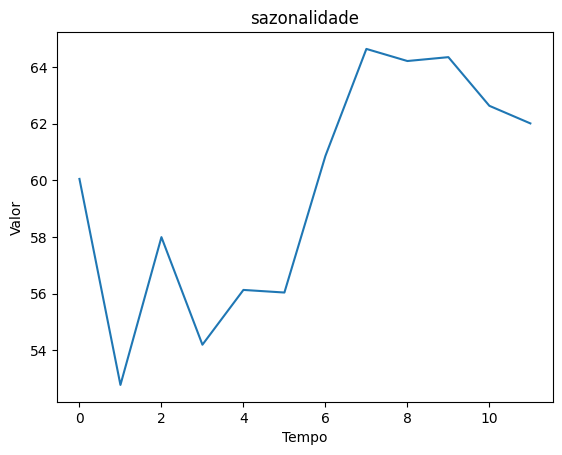

,sazonalidade
sazonalidade,
0,60.045250
1,52.776950
2,57.991125
3,54.195300
4,56.128400
5,56.036400
6,60.854450
7,64.631150
8,64.204400


In [33]:
def calculate_monthly_means(consume_of_cement, subject):
    df = pd.DataFrame({subject: consume_of_cement})
    df['sazonalidade'] = df.index % 12
    monthly_means = df.groupby('sazonalidade')[subject].mean()
    result_df = pd.DataFrame({'sazonalidade': monthly_means})

    return result_df

media_df = calculate_monthly_means(data[subject], subject)
plot_columns(media_df)
media_df

In [34]:
def fill_original_df_with_monthly_means(df_og, media_df):
    monthly_means = media_df['sazonalidade'].tolist()
    df_og['sazonalidade'] = [monthly_means[i % 12] for i in range(len(df_og))]
    return df_og

data = fill_original_df_with_monthly_means(data, media_df)
data = data[[col for col in data.columns if col != subject] + [subject]] #Seta consumo (target) para a coluna final
data

,Unnamed: 0,Rio Grande do Norte - IDH,IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),Taxa Selic (%),IGP-DI,População,Estoque liquido de capital fixo - (R$),INCC (%),Rio Grande Do Norte - Produção de Cimento (t),Rio Grande do Norte - PIB - Estadual,Rio Grande do Norte - PIB - Construção Civil,Rio Grande do Norte - PIB - Per Capita,Rio Grande do Norte - PIB - Preços de Mercado,Rio Grande do Norte - Desemprego,sazonalidade,Rio Grande Do Norte - Consumo de Cimento (t)
0,2003-1,0.689488,0.724032,-5331.049150,11.520143,1.639718,1.036534,1.772069e+08,7.330309e+06,0.969649,27.698760,3.164847e+07,1.998664e+06,9.097985,2.879532e+07,8.294170,60.045250,36.825
1,2003-2,0.689892,0.690297,-5318.079644,11.189862,1.378899,0.993449,1.773884e+08,7.335910e+06,0.950783,27.407645,3.168897e+07,2.001107e+06,9.101271,2.881033e+07,8.288224,52.776950,34.088
2,2003-3,0.690297,0.669681,-5436.417870,10.820792,1.924317,0.973020,1.775699e+08,7.341511e+06,0.938332,27.377422,3.172947e+07,2.003550e+06,9.104557,2.882535e+07,8.282278,57.991125,30.150
3,2003-4,0.690702,0.660494,-5707.015274,10.417840,1.331174,0.940489,1.777514e+08,7.347112e+06,0.926401,27.542280,3.176997e+07,2.005994e+06,9.107843,2.884036e+07,8.276332,54.195300,31.224
4,2003-5,0.691107,0.648337,-5599.317941,9.959690,1.736072,0.917493,1.779329e+08,7.352713e+06,0.951683,27.944900,3.181046e+07,2.008437e+06,9.111128,2.885538e+07,8.270387,56.128400,33.606
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
235,2022-8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,95.557326,NaN,NaN,NaN,NaN,NaN,64.631150,83.890
236,2022-9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,94.910014,NaN,NaN,NaN,NaN,NaN,64.204400,83.438
237,2022-10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,94.800783,NaN,NaN,NaN,NaN,NaN,64.340900,80.005
238,2022-11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,94.752983,NaN,NaN,NaN,NaN,NaN,62.624200,75.441


In [35]:
# Shift para prever futuro e não presente
target_data = data[subject].shift(-24)
target_data

0      38.146
1      30.350
2      33.791
3      30.891
4      30.724
        ...  
235       NaN
236       NaN
237       NaN
238       NaN
239       NaN
Name: Rio Grande Do Norte - Consumo de Cimento (t), Length: 240, dtype: float64

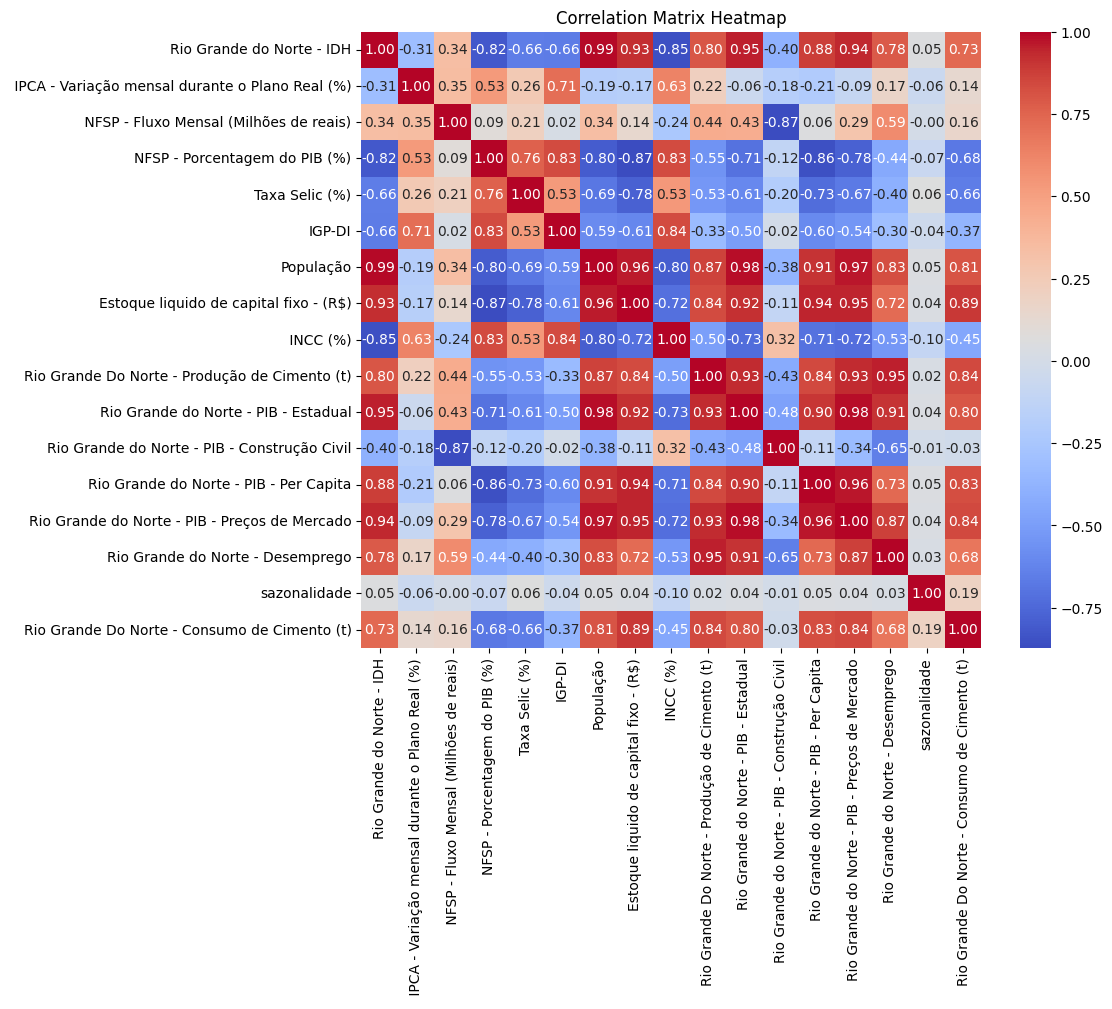

In [36]:
plot_data = data.iloc[:split_index + 1,1:]
plot_correlation_matrix(plot_data)

In [37]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

safe_data = data.iloc[:split_index + 1,1:-1]

def calculate_vif(dataframe):
    vif_data = pd.DataFrame()
    vif_data["Feature"] = dataframe.columns
    vif_data["VIF"] = [variance_inflation_factor(dataframe.values, i) for i in range(dataframe.shape[1])]
    return vif_data

def remove_high_vif_columns(dataframe, threshold=1000):
    i=0
    while True:
        vif_result = calculate_vif(dataframe)
        high_vif_column = vif_result.loc[vif_result["VIF"].idxmax()]["Feature"]
        
        if vif_result["VIF"].max() <= threshold:
            print(f"Num columns removed: {i}")
            return dataframe
        i += 1
        dataframe = dataframe.drop(high_vif_column, axis=1)

In [38]:
safe_data = data.iloc[:split_index + 1,1:-1]
vif_info = calculate_vif(safe_data)
vif_info

,Feature,VIF
0,Rio Grande do Norte - IDH,1.351464e+06
1,IPCA - Variação mensal durante o Plano Real (%),1.063689e+03
2,NFSP - Fluxo Mensal (Milhões de reais),2.338379e+02
3,NFSP - Porcentagem do PIB (%),2.749578e+02
4,Taxa Selic (%),5.626603e+01
5,IGP-DI,2.848267e+02
6,População,2.416519e+06
7,Estoque liquido de capital fixo - (R$),5.404123e+06
8,INCC (%),1.038580e+03
9,Rio Grande Do Norte - Produção de Cimento (t),2.535644e+03


In [39]:
data = remove_high_vif_columns(safe_data, 10000000)
data

Num columns removed: 1


,Rio Grande do Norte - IDH,IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),Taxa Selic (%),IGP-DI,População,Estoque liquido de capital fixo - (R$),INCC (%),Rio Grande Do Norte - Produção de Cimento (t),Rio Grande do Norte - PIB - Estadual,Rio Grande do Norte - PIB - Construção Civil,Rio Grande do Norte - PIB - Per Capita,Rio Grande do Norte - Desemprego,sazonalidade
0,0.689488,0.724032,-5331.049150,11.520143,1.639718,1.036534,1.772069e+08,7.330309e+06,0.969649,27.698760,3.164847e+07,1.998664e+06,9.097985,8.294170,60.045250
1,0.689892,0.690297,-5318.079644,11.189862,1.378899,0.993449,1.773884e+08,7.335910e+06,0.950783,27.407645,3.168897e+07,2.001107e+06,9.101271,8.288224,52.776950
2,0.690297,0.669681,-5436.417870,10.820792,1.924317,0.973020,1.775699e+08,7.341511e+06,0.938332,27.377422,3.172947e+07,2.003550e+06,9.104557,8.282278,57.991125
3,0.690702,0.660494,-5707.015274,10.417840,1.331174,0.940489,1.777514e+08,7.347112e+06,0.926401,27.542280,3.176997e+07,2.005994e+06,9.107843,8.276332,54.195300
4,0.691107,0.648337,-5599.317941,9.959690,1.736072,0.917493,1.779329e+08,7.352713e+06,0.951683,27.944900,3.181046e+07,2.008437e+06,9.111128,8.270387,56.128400
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
175,0.728882,0.366904,-5783.316460,2.206994,0.545067,0.471521,1.987710e+08,7.783063e+06,0.378150,80.136073,3.753144e+07,1.955482e+06,9.240251,13.086992,64.631150
176,0.728888,0.358935,-6001.730740,2.215328,0.782910,0.476827,1.988450e+08,7.780841e+06,0.377666,79.367321,3.752295e+07,1.955479e+06,9.239764,13.080150,64.204400
177,0.728894,0.354313,-6454.887704,2.232466,0.909682,0.475427,1.989190e+08,7.778619e+06,0.377838,78.709496,3.751445e+07,1.955477e+06,9.239278,13.073309,64.340900
178,0.728901,0.352728,-6243.191421,2.263185,1.050614,0.491301,1.989930e+08,7.776397e+06,0.370057,78.131255,3.750595e+07,1.955475e+06,9.238791,13.066467,62.624200


In [40]:
input_data = data.iloc[:split_index + 1,1:-1]
mean = np.mean(input_data, axis=0)
stddev =  np.std(input_data, axis=0)
input_data = ((input_data - mean) /stddev)
# scaler=MinMaxScaler()
# scaled_data = scaler.fit_transform(input_data)
# input_data = pd.DataFrame(scaled_data, columns=input_data.columns)
input_data

,IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),Taxa Selic (%),IGP-DI,População,Estoque liquido de capital fixo - (R$),INCC (%),Rio Grande Do Norte - Produção de Cimento (t),Rio Grande do Norte - PIB - Estadual,Rio Grande do Norte - PIB - Construção Civil,Rio Grande do Norte - PIB - Per Capita,Rio Grande do Norte - Desemprego
0,2.802383,0.604311,4.268118,2.039314,3.921218,-2.016914,-2.299937,3.214079,-1.126279,-1.675640,-0.939011,-2.687307,-0.811236
1,2.402642,0.609431,4.096014,1.195209,3.582946,-1.988421,-2.263992,3.051841,-1.135235,-1.655248,-0.886466,-2.608034,-0.813666
2,2.158351,0.562720,3.903698,2.960381,3.422548,-1.959928,-2.228047,2.944772,-1.136165,-1.634857,-0.833921,-2.528760,-0.816096
3,2.049492,0.455907,3.693727,1.040752,3.167136,-1.931435,-2.192102,2.842174,-1.131093,-1.614465,-0.781376,-2.449487,-0.818526
4,1.905441,0.498418,3.454992,2.351150,2.986591,-1.902941,-2.156157,3.059587,-1.118707,-1.594073,-0.728831,-2.370214,-0.820957
...,...,...,...,...,...,...,...,...,...,...,...,...,...
175,-1.429358,0.425789,-0.584804,-1.503380,-0.514871,1.368581,0.605679,-1.872446,0.486880,1.286547,-1.867690,0.744977,1.147646
176,-1.523783,0.339575,-0.580461,-0.733634,-0.473208,1.380202,0.591420,-1.876611,0.463230,1.282269,-1.867743,0.733240,1.144850
177,-1.578548,0.160702,-0.571531,-0.323353,-0.484199,1.391823,0.577161,-1.875135,0.442993,1.277991,-1.867795,0.721502,1.142053
178,-1.597335,0.244264,-0.555524,0.132757,-0.359568,1.403443,0.562902,-1.942040,0.425205,1.273713,-1.867847,0.709765,1.139257


In [41]:
# input para treinamento
train_input = input_data.iloc[start_index:train_split]
train_input

,IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),Taxa Selic (%),IGP-DI,População,Estoque liquido de capital fixo - (R$),INCC (%),Rio Grande Do Norte - Produção de Cimento (t),Rio Grande do Norte - PIB - Estadual,Rio Grande do Norte - PIB - Construção Civil,Rio Grande do Norte - PIB - Per Capita,Rio Grande do Norte - Desemprego
0,2.802383,0.604311,4.268118,2.039314,3.921218,-2.016914,-2.299937,3.214079,-1.126279,-1.675640,-0.939011,-2.687307,-0.811236
1,2.402642,0.609431,4.096014,1.195209,3.582946,-1.988421,-2.263992,3.051841,-1.135235,-1.655248,-0.886466,-2.608034,-0.813666
2,2.158351,0.562720,3.903698,2.960381,3.422548,-1.959928,-2.228047,2.944772,-1.136165,-1.634857,-0.833921,-2.528760,-0.816096
3,2.049492,0.455907,3.693727,1.040752,3.167136,-1.931435,-2.192102,2.842174,-1.131093,-1.614465,-0.781376,-2.449487,-0.818526
4,1.905441,0.498418,3.454992,2.351150,2.986591,-1.902941,-2.156157,3.059587,-1.118707,-1.594073,-0.728831,-2.370214,-0.820957
...,...,...,...,...,...,...,...,...,...,...,...,...,...
163,-0.960452,1.465326,-0.676734,0.472779,-1.087000,1.228701,0.759879,-1.491033,0.827055,1.296571,-1.765982,0.743657,1.223628
164,-1.007966,1.351131,-0.668750,0.302784,-0.904679,1.240408,0.749001,-1.525186,0.802726,1.300555,-1.786251,0.760354,1.212346
165,-0.976556,1.143146,-0.657609,0.339539,-0.900134,1.252114,0.738124,-1.546744,0.781969,1.304540,-1.806519,0.777050,1.201065
166,-1.146834,1.542609,-0.647588,0.472795,-1.136836,1.263821,0.727246,-1.586381,0.765539,1.308525,-1.826787,0.793747,1.189783


In [42]:
# Alvo para treinamento
train_target = target_data.iloc[start_index:train_split]
train_target

0      38.146
1      30.350
2      33.791
3      30.891
4      30.724
        ...  
163    48.520
164    41.365
165    43.813
166    43.816
167    38.245
Name: Rio Grande Do Norte - Consumo de Cimento (t), Length: 168, dtype: float64

In [43]:
def create_batches(t_input, t_target, window_size, start_from):
    
    X_batches = []
    y_batches = []

    train_input_values = t_input.values 

    for i in range(len(t_input) - window_size):
        
        X_window = train_input_values[i:i+window_size, :]
        y_target = t_target[start_from+i+window_size]

        X_batches.append(X_window)
        y_batches.append(y_target)

    return np.array(X_batches), np.array(y_batches)

In [44]:
reshaped_train, reshaped_target = create_batches(train_input, 
                                                 train_target, 
                                                 window_size, 
                                                 start_index)
reshaped_train.shape

(132, 36, 13)

In [45]:
# input para treinamento
test_input = input_data.iloc[train_split - window_size:split_index + 1]
test_input

,IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),Taxa Selic (%),IGP-DI,População,Estoque liquido de capital fixo - (R$),INCC (%),Rio Grande Do Norte - Produção de Cimento (t),Rio Grande do Norte - PIB - Estadual,Rio Grande do Norte - PIB - Construção Civil,Rio Grande do Norte - PIB - Per Capita,Rio Grande do Norte - Desemprego
132,1.530065,0.817451,-0.366715,-0.530011,0.174628,0.848407,0.965586,-0.066954,1.465443,1.012160,-0.377404,0.813762,1.214801
133,1.649361,1.130195,-0.350285,-0.532694,0.240832,0.861179,0.962419,-0.130652,1.453564,1.025325,-0.429646,0.804671,1.223335
134,1.622916,1.160498,-0.335122,-0.186421,0.176857,0.873950,0.959252,-0.079602,1.450441,1.038489,-0.481889,0.795579,1.231870
135,1.581460,1.131990,-0.321950,-0.719664,-0.005233,0.886722,0.956085,-0.034473,1.446041,1.051654,-0.534131,0.786488,1.240405
136,1.638292,1.384387,-0.302995,-0.798520,0.097576,0.899493,0.952918,-0.177535,1.440508,1.064818,-0.586373,0.777397,1.248939
137,1.643773,1.375487,-0.290554,-0.612129,0.431487,0.912265,0.949751,-0.208868,1.433746,1.077982,-0.638616,0.768305,1.257474
138,1.704584,1.438928,-0.281926,-0.476740,0.482414,0.925036,0.946584,-0.245300,1.425836,1.091147,-0.690858,0.759214,1.266009
139,1.841703,1.569590,-0.275931,-0.211736,0.657043,0.937808,0.943417,-0.333490,1.416841,1.104311,-0.743100,0.750123,1.274543
140,1.837218,1.584058,-0.271466,-0.484608,0.678386,0.950580,0.940250,-0.296846,1.406794,1.117475,-0.795343,0.741031,1.283078
141,1.797860,1.166380,-0.273241,-0.183907,0.727143,0.963351,0.937082,-0.292462,1.395804,1.130640,-0.847585,0.731940,1.291613


In [46]:
reshaped_test, reshaped_test_target = create_batches(test_input, 
                                                     target_data, 
                                                     window_size, 
                                                     train_split - window_size)
reshaped_test.shape 

(12, 36, 13)

In [47]:
def validation_splitter(arr, div_factor, add_factor=0):
    split_factor = len(arr) // div_factor
    positions_to_drop_index = []
    positions_to_drop = []
    for i in range(split_factor):
        pos = len(arr) - (i * div_factor + 1)
        positions_to_drop_index.append(pos)
        positions_to_drop.append(pos + add_factor)
    
    arr_droped = arr[positions_to_drop]
    arr_result = np.delete(arr, positions_to_drop_index, axis=0)
    
    return arr_result, arr_droped

In [48]:
# Rede Neural Recorrente com optmizador Estocástico
def lstm_model(train_input, train_target, want_verbose=1, seed=0):
    if seed != 0:
        random.seed(seed)
        np.random.seed(seed)
        tf.random.set_seed(seed)
    # Aṕos 500 epochs sem grandes melhoras no val_loss, interrompe.
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
                                                      patience=500, 
                                                      verbose=want_verbose, 
                                                      restore_best_weights=True,
                                                      start_from_epoch=500)
    # Método estocástico e learning rate=0.005
    optimizer = tf.keras.optimizers.SGD(learning_rate=0.005)
    model = tf.keras.Sequential([
        tf.keras.layers.LSTM(72, activation='tanh', 
                            return_sequences=True, 
                            kernel_regularizer=tf.keras.regularizers.l2(0.01),  
                            input_shape=(reshaped_train.shape[1], reshaped_train.shape[2])),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.LSTM(36, activation='tanh', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
        tf.keras.layers.Dense(1)
    ])
    model.compile(optimizer=optimizer,
                  loss='mean_squared_error')    
    history = model.fit(train_input, 
                        train_target, 
                        epochs=10000,
                        validation_split=0.1,
                        callbacks=[early_stopping], 
                        verbose=want_verbose)
    return model, history

In [49]:
def get_a_good_seed(train_input, train_target, test_input, test_target):

    random_seeds = [random.randint(0, 2**32 - 1) for _ in range(10)]
    print(random_seeds)

    best_loss = float('inf')
    winner_seed = None
    i = 0
    for seed in random_seeds:
        print(f"\n\nStep: {i} ___________________________________________")
        i += 1

        model, history = lstm_model(train_input, train_target, want_verbose=0, seed=seed)
        current_loss = min(history.history['val_loss'][500:])
        print(f"val_loss: {current_loss}")

        if current_loss < best_loss:
            best_loss = current_loss
            winner_seed = seed
            print(f"winner_seed: {winner_seed}")
            if winner_seed == 0.0:
                return winner_seed

    return winner_seed

In [50]:
winner_seed = get_a_good_seed(reshaped_train, reshaped_target, reshaped_test, reshaped_test_target)
print(f"\n\nfinal_seed: {winner_seed}")

[3469707959, 1619401159, 680788258, 3141004446, 1647917570, 633645560, 1224444235, 1914004406, 3464857725, 4179203804]


Step: 0 ___________________________________________
val_loss: 163.9718017578125
winner_seed: 3469707959


Step: 1 ___________________________________________
val_loss: 169.51864624023438


Step: 2 ___________________________________________
val_loss: 224.8438262939453


Step: 3 ___________________________________________
val_loss: 178.3045654296875


Step: 4 ___________________________________________
val_loss: 94.8564682006836
winner_seed: 1647917570


Step: 5 ___________________________________________
val_loss: 80.00138092041016
winner_seed: 633645560


Step: 6 ___________________________________________
val_loss: 183.2910919189453


Step: 7 ___________________________________________
val_loss: 73.06745910644531
winner_seed: 1914004406


Step: 8 ___________________________________________
val_loss: 169.5303497314453


Step: 9 ______________________________________

In [51]:
trained_model, history = lstm_model(reshaped_train, 
                                    reshaped_target, 
                                    want_verbose=1, 
                                    seed=winner_seed)
# 2652417522

Epoch 1/10000
4/4 [==============================] - 2s 143ms/step - loss: 4220.2451 - val_loss: 42.8904
Epoch 2/10000
4/4 [==============================] - 0s 11ms/step - loss: 610.2260 - val_loss: 612.1410
Epoch 3/10000
4/4 [==============================] - 0s 11ms/step - loss: 149.8708 - val_loss: 881.6143
Epoch 4/10000
4/4 [==============================] - 0s 11ms/step - loss: 137.3140 - val_loss: 923.7510
Epoch 5/10000
4/4 [==============================] - 0s 11ms/step - loss: 329.6782 - val_loss: 686.1214
Epoch 6/10000
4/4 [==============================] - 0s 10ms/step - loss: 1415.1538 - val_loss: 709.7844
Epoch 7/10000
4/4 [==============================] - 0s 10ms/step - loss: 136.7604 - val_loss: 479.2546
Epoch 8/10000
4/4 [==============================] - 0s 11ms/step - loss: 116.0157 - val_loss: 325.2674
Epoch 9/10000
4/4 [==============================] - 0s 10ms/step - loss: 114.1011 - val_loss: 231.5277
Epoch 10/10000
4/4 [==============================] - 0s 10ms/

Epoch 80/10000
4/4 [==============================] - 0s 10ms/step - loss: 47.0277 - val_loss: 224.6870
Epoch 81/10000
4/4 [==============================] - 0s 11ms/step - loss: 48.6211 - val_loss: 215.7127
Epoch 82/10000
4/4 [==============================] - 0s 11ms/step - loss: 45.6796 - val_loss: 210.4349
Epoch 83/10000
4/4 [==============================] - 0s 11ms/step - loss: 46.0871 - val_loss: 195.9095
Epoch 84/10000
4/4 [==============================] - 0s 10ms/step - loss: 53.2812 - val_loss: 210.1653
Epoch 85/10000
4/4 [==============================] - 0s 10ms/step - loss: 47.7449 - val_loss: 205.8427
Epoch 86/10000
4/4 [==============================] - 0s 11ms/step - loss: 46.7380 - val_loss: 201.0385
Epoch 87/10000
4/4 [==============================] - 0s 10ms/step - loss: 49.5791 - val_loss: 211.9379
Epoch 88/10000
4/4 [==============================] - 0s 10ms/step - loss: 47.6185 - val_loss: 226.8715
Epoch 89/10000
4/4 [==============================] - 0s 10ms/st

4/4 [==============================] - 0s 10ms/step - loss: 43.0945 - val_loss: 191.8371
Epoch 159/10000
4/4 [==============================] - 0s 11ms/step - loss: 43.1083 - val_loss: 208.4885
Epoch 160/10000
4/4 [==============================] - 0s 10ms/step - loss: 42.5475 - val_loss: 203.9351
Epoch 161/10000
4/4 [==============================] - 0s 9ms/step - loss: 42.5830 - val_loss: 210.4728
Epoch 162/10000
4/4 [==============================] - 0s 10ms/step - loss: 43.8180 - val_loss: 214.8534
Epoch 163/10000
4/4 [==============================] - 0s 11ms/step - loss: 47.5591 - val_loss: 222.2728
Epoch 164/10000
4/4 [==============================] - 0s 10ms/step - loss: 47.4470 - val_loss: 205.0448
Epoch 165/10000
4/4 [==============================] - 0s 10ms/step - loss: 45.7817 - val_loss: 204.7782
Epoch 166/10000
4/4 [==============================] - 0s 10ms/step - loss: 44.4067 - val_loss: 201.4874
Epoch 167/10000
4/4 [==============================] - 0s 11ms/step - lo

4/4 [==============================] - 0s 11ms/step - loss: 44.2581 - val_loss: 212.1982
Epoch 237/10000
4/4 [==============================] - 0s 10ms/step - loss: 42.2215 - val_loss: 207.2484
Epoch 238/10000
4/4 [==============================] - 0s 10ms/step - loss: 42.9683 - val_loss: 197.1630
Epoch 239/10000
4/4 [==============================] - 0s 10ms/step - loss: 41.6609 - val_loss: 203.6767
Epoch 240/10000
4/4 [==============================] - 0s 11ms/step - loss: 40.6946 - val_loss: 199.5944
Epoch 241/10000
4/4 [==============================] - 0s 11ms/step - loss: 39.9126 - val_loss: 208.3631
Epoch 242/10000
4/4 [==============================] - 0s 11ms/step - loss: 40.8050 - val_loss: 200.0033
Epoch 243/10000
4/4 [==============================] - 0s 12ms/step - loss: 42.9550 - val_loss: 202.7541
Epoch 244/10000
4/4 [==============================] - 0s 11ms/step - loss: 40.0973 - val_loss: 197.0814
Epoch 245/10000
4/4 [==============================] - 0s 12ms/step - l

4/4 [==============================] - 0s 12ms/step - loss: 40.4863 - val_loss: 175.6042
Epoch 315/10000
4/4 [==============================] - 0s 12ms/step - loss: 40.3262 - val_loss: 207.5264
Epoch 316/10000
4/4 [==============================] - 0s 13ms/step - loss: 42.4526 - val_loss: 179.6832
Epoch 317/10000
4/4 [==============================] - 0s 11ms/step - loss: 40.8702 - val_loss: 190.0596
Epoch 318/10000
4/4 [==============================] - 0s 12ms/step - loss: 41.3789 - val_loss: 195.4906
Epoch 319/10000
4/4 [==============================] - 0s 12ms/step - loss: 40.8236 - val_loss: 196.9493
Epoch 320/10000
4/4 [==============================] - 0s 11ms/step - loss: 39.8127 - val_loss: 201.7100
Epoch 321/10000
4/4 [==============================] - 0s 11ms/step - loss: 43.5386 - val_loss: 208.7470
Epoch 322/10000
4/4 [==============================] - 0s 11ms/step - loss: 40.2611 - val_loss: 214.5420
Epoch 323/10000
4/4 [==============================] - 0s 10ms/step - l

4/4 [==============================] - 0s 11ms/step - loss: 36.6759 - val_loss: 191.5506
Epoch 393/10000
4/4 [==============================] - 0s 11ms/step - loss: 37.4489 - val_loss: 193.5388
Epoch 394/10000
4/4 [==============================] - 0s 11ms/step - loss: 38.2473 - val_loss: 199.8518
Epoch 395/10000
4/4 [==============================] - 0s 10ms/step - loss: 38.6977 - val_loss: 193.0889
Epoch 396/10000
4/4 [==============================] - 0s 11ms/step - loss: 37.7491 - val_loss: 196.4979
Epoch 397/10000
4/4 [==============================] - 0s 12ms/step - loss: 37.9826 - val_loss: 200.9478
Epoch 398/10000
4/4 [==============================] - 0s 12ms/step - loss: 38.5842 - val_loss: 200.9815
Epoch 399/10000
4/4 [==============================] - 0s 11ms/step - loss: 38.1510 - val_loss: 190.3695
Epoch 400/10000
4/4 [==============================] - 0s 11ms/step - loss: 39.3060 - val_loss: 195.0174
Epoch 401/10000
4/4 [==============================] - 0s 10ms/step - l

4/4 [==============================] - 0s 11ms/step - loss: 36.8106 - val_loss: 198.8156
Epoch 471/10000
4/4 [==============================] - 0s 11ms/step - loss: 35.8200 - val_loss: 197.8174
Epoch 472/10000
4/4 [==============================] - 0s 11ms/step - loss: 36.7053 - val_loss: 196.4842
Epoch 473/10000
4/4 [==============================] - 0s 11ms/step - loss: 35.8951 - val_loss: 196.5653
Epoch 474/10000
4/4 [==============================] - 0s 12ms/step - loss: 37.7277 - val_loss: 194.1504
Epoch 475/10000
4/4 [==============================] - 0s 11ms/step - loss: 37.5852 - val_loss: 192.5900
Epoch 476/10000
4/4 [==============================] - 0s 12ms/step - loss: 37.8514 - val_loss: 186.8279
Epoch 477/10000
4/4 [==============================] - 0s 11ms/step - loss: 36.8933 - val_loss: 193.5402
Epoch 478/10000
4/4 [==============================] - 0s 10ms/step - loss: 35.5766 - val_loss: 196.9412
Epoch 479/10000
4/4 [==============================] - 0s 10ms/step - l

4/4 [==============================] - 0s 11ms/step - loss: 36.4656 - val_loss: 194.5717
Epoch 549/10000
4/4 [==============================] - 0s 11ms/step - loss: 33.8288 - val_loss: 195.3563
Epoch 550/10000
4/4 [==============================] - 0s 10ms/step - loss: 33.6890 - val_loss: 201.7404
Epoch 551/10000
4/4 [==============================] - 0s 10ms/step - loss: 32.3695 - val_loss: 195.0410
Epoch 552/10000
4/4 [==============================] - 0s 10ms/step - loss: 33.5667 - val_loss: 181.0839
Epoch 553/10000
4/4 [==============================] - 0s 10ms/step - loss: 33.8961 - val_loss: 196.1095
Epoch 554/10000
4/4 [==============================] - 0s 11ms/step - loss: 33.0674 - val_loss: 198.3730
Epoch 555/10000
4/4 [==============================] - 0s 11ms/step - loss: 35.8153 - val_loss: 185.8064
Epoch 556/10000
4/4 [==============================] - 0s 11ms/step - loss: 36.2213 - val_loss: 184.2106
Epoch 557/10000
4/4 [==============================] - 0s 11ms/step - l

4/4 [==============================] - 0s 11ms/step - loss: 35.4381 - val_loss: 197.4635
Epoch 627/10000
4/4 [==============================] - 0s 11ms/step - loss: 32.6450 - val_loss: 193.8138
Epoch 628/10000
4/4 [==============================] - 0s 11ms/step - loss: 38.9942 - val_loss: 186.3596
Epoch 629/10000
4/4 [==============================] - 0s 12ms/step - loss: 35.4349 - val_loss: 200.3459
Epoch 630/10000
4/4 [==============================] - 0s 11ms/step - loss: 33.7112 - val_loss: 198.1077
Epoch 631/10000
4/4 [==============================] - 0s 9ms/step - loss: 30.5888 - val_loss: 192.7221
Epoch 632/10000
4/4 [==============================] - 0s 10ms/step - loss: 31.5937 - val_loss: 186.7104
Epoch 633/10000
4/4 [==============================] - 0s 11ms/step - loss: 32.6468 - val_loss: 191.6393
Epoch 634/10000
4/4 [==============================] - 0s 10ms/step - loss: 32.1527 - val_loss: 195.2393
Epoch 635/10000
4/4 [==============================] - 0s 10ms/step - lo

4/4 [==============================] - 0s 10ms/step - loss: 30.7941 - val_loss: 189.0336
Epoch 705/10000
4/4 [==============================] - 0s 11ms/step - loss: 30.6805 - val_loss: 198.7153
Epoch 706/10000
4/4 [==============================] - 0s 11ms/step - loss: 28.9132 - val_loss: 190.7713
Epoch 707/10000
4/4 [==============================] - 0s 10ms/step - loss: 28.8557 - val_loss: 194.6706
Epoch 708/10000
4/4 [==============================] - 0s 10ms/step - loss: 32.0122 - val_loss: 196.2488
Epoch 709/10000
4/4 [==============================] - 0s 11ms/step - loss: 30.2779 - val_loss: 187.3853
Epoch 710/10000
4/4 [==============================] - 0s 11ms/step - loss: 36.0173 - val_loss: 191.2044
Epoch 711/10000
4/4 [==============================] - 0s 11ms/step - loss: 29.2619 - val_loss: 181.3141
Epoch 712/10000
4/4 [==============================] - 0s 10ms/step - loss: 32.3938 - val_loss: 187.8461
Epoch 713/10000
4/4 [==============================] - 0s 11ms/step - l

4/4 [==============================] - 0s 10ms/step - loss: 31.9116 - val_loss: 185.3168
Epoch 783/10000
4/4 [==============================] - 0s 11ms/step - loss: 32.5032 - val_loss: 187.4671
Epoch 784/10000
4/4 [==============================] - 0s 11ms/step - loss: 29.0898 - val_loss: 184.0077
Epoch 785/10000
4/4 [==============================] - 0s 10ms/step - loss: 28.2559 - val_loss: 182.9373
Epoch 786/10000
4/4 [==============================] - 0s 11ms/step - loss: 27.4868 - val_loss: 188.3772
Epoch 787/10000
4/4 [==============================] - 0s 10ms/step - loss: 26.9637 - val_loss: 197.8912
Epoch 788/10000
4/4 [==============================] - 0s 10ms/step - loss: 32.5172 - val_loss: 187.5441
Epoch 789/10000
4/4 [==============================] - 0s 10ms/step - loss: 30.0789 - val_loss: 193.0587
Epoch 790/10000
4/4 [==============================] - 0s 10ms/step - loss: 29.6528 - val_loss: 181.1321
Epoch 791/10000
4/4 [==============================] - 0s 10ms/step - l

4/4 [==============================] - 0s 9ms/step - loss: 26.9026 - val_loss: 190.4633
Epoch 861/10000
4/4 [==============================] - 0s 11ms/step - loss: 27.6924 - val_loss: 190.8390
Epoch 862/10000
4/4 [==============================] - 0s 11ms/step - loss: 26.9952 - val_loss: 192.0440
Epoch 863/10000
4/4 [==============================] - 0s 9ms/step - loss: 26.7332 - val_loss: 188.3560
Epoch 864/10000
4/4 [==============================] - 0s 12ms/step - loss: 25.9264 - val_loss: 178.7440
Epoch 865/10000
4/4 [==============================] - 0s 10ms/step - loss: 28.2190 - val_loss: 182.3675
Epoch 866/10000
4/4 [==============================] - 0s 10ms/step - loss: 28.4741 - val_loss: 181.0320
Epoch 867/10000
4/4 [==============================] - 0s 10ms/step - loss: 27.1805 - val_loss: 184.8468
Epoch 868/10000
4/4 [==============================] - 0s 11ms/step - loss: 31.0821 - val_loss: 194.1710
Epoch 869/10000
4/4 [==============================] - 0s 10ms/step - los

4/4 [==============================] - 0s 11ms/step - loss: 25.5526 - val_loss: 174.7157
Epoch 939/10000
4/4 [==============================] - 0s 12ms/step - loss: 27.6509 - val_loss: 176.4086
Epoch 940/10000
4/4 [==============================] - 0s 12ms/step - loss: 27.4461 - val_loss: 176.9142
Epoch 941/10000
4/4 [==============================] - 0s 11ms/step - loss: 27.2660 - val_loss: 181.1648
Epoch 942/10000
4/4 [==============================] - 0s 11ms/step - loss: 26.6649 - val_loss: 164.0238
Epoch 943/10000
4/4 [==============================] - 0s 10ms/step - loss: 27.5155 - val_loss: 175.5153
Epoch 944/10000
4/4 [==============================] - 0s 11ms/step - loss: 26.1234 - val_loss: 171.3827
Epoch 945/10000
4/4 [==============================] - 0s 11ms/step - loss: 25.0437 - val_loss: 167.6199
Epoch 946/10000
4/4 [==============================] - 0s 11ms/step - loss: 23.5663 - val_loss: 171.4473
Epoch 947/10000
4/4 [==============================] - 0s 10ms/step - l

4/4 [==============================] - 0s 10ms/step - loss: 24.0011 - val_loss: 170.9400
Epoch 1017/10000
4/4 [==============================] - 0s 11ms/step - loss: 26.0240 - val_loss: 182.2169
Epoch 1018/10000
4/4 [==============================] - 0s 11ms/step - loss: 24.5369 - val_loss: 178.8844
Epoch 1019/10000
4/4 [==============================] - 0s 10ms/step - loss: 25.0278 - val_loss: 173.0447
Epoch 1020/10000
4/4 [==============================] - 0s 11ms/step - loss: 24.1235 - val_loss: 181.5934
Epoch 1021/10000
4/4 [==============================] - 0s 11ms/step - loss: 23.5108 - val_loss: 164.0908
Epoch 1022/10000
4/4 [==============================] - 0s 11ms/step - loss: 24.6704 - val_loss: 179.5976
Epoch 1023/10000
4/4 [==============================] - 0s 11ms/step - loss: 24.8964 - val_loss: 177.5113
Epoch 1024/10000
4/4 [==============================] - 0s 10ms/step - loss: 25.8870 - val_loss: 184.2216
Epoch 1025/10000
4/4 [==============================] - 0s 10ms

4/4 [==============================] - 0s 10ms/step - loss: 24.5931 - val_loss: 174.5769
Epoch 1094/10000
4/4 [==============================] - 0s 11ms/step - loss: 22.9898 - val_loss: 161.5470
Epoch 1095/10000
4/4 [==============================] - 0s 11ms/step - loss: 23.4034 - val_loss: 170.1710
Epoch 1096/10000
4/4 [==============================] - 0s 11ms/step - loss: 23.0402 - val_loss: 177.2334
Epoch 1097/10000
4/4 [==============================] - 0s 11ms/step - loss: 25.2976 - val_loss: 168.4146
Epoch 1098/10000
4/4 [==============================] - 0s 12ms/step - loss: 27.7891 - val_loss: 170.3096
Epoch 1099/10000
4/4 [==============================] - 0s 11ms/step - loss: 22.2830 - val_loss: 192.1789
Epoch 1100/10000
4/4 [==============================] - 0s 11ms/step - loss: 23.7999 - val_loss: 185.0937
Epoch 1101/10000
4/4 [==============================] - 0s 12ms/step - loss: 22.6888 - val_loss: 184.5058
Epoch 1102/10000
4/4 [==============================] - 0s 10ms

4/4 [==============================] - 0s 11ms/step - loss: 21.4669 - val_loss: 171.3413
Epoch 1171/10000
4/4 [==============================] - 0s 10ms/step - loss: 21.2099 - val_loss: 165.1805
Epoch 1172/10000
4/4 [==============================] - 0s 11ms/step - loss: 22.1548 - val_loss: 173.1635
Epoch 1173/10000
4/4 [==============================] - 0s 10ms/step - loss: 20.5921 - val_loss: 184.8671
Epoch 1174/10000
4/4 [==============================] - 0s 11ms/step - loss: 21.2124 - val_loss: 171.8806
Epoch 1175/10000
4/4 [==============================] - 0s 10ms/step - loss: 21.3127 - val_loss: 170.8171
Epoch 1176/10000
4/4 [==============================] - 0s 10ms/step - loss: 19.9603 - val_loss: 170.2782
Epoch 1177/10000
4/4 [==============================] - 0s 10ms/step - loss: 21.6769 - val_loss: 149.7739
Epoch 1178/10000
4/4 [==============================] - 0s 11ms/step - loss: 21.7197 - val_loss: 149.6617
Epoch 1179/10000
4/4 [==============================] - 0s 11ms

4/4 [==============================] - 0s 11ms/step - loss: 21.4570 - val_loss: 158.6484
Epoch 1248/10000
4/4 [==============================] - 0s 11ms/step - loss: 21.6821 - val_loss: 154.6598
Epoch 1249/10000
4/4 [==============================] - 0s 11ms/step - loss: 21.3773 - val_loss: 157.0926
Epoch 1250/10000
4/4 [==============================] - 0s 11ms/step - loss: 21.8532 - val_loss: 144.8881
Epoch 1251/10000
4/4 [==============================] - 0s 11ms/step - loss: 20.2617 - val_loss: 166.9376
Epoch 1252/10000
4/4 [==============================] - 0s 11ms/step - loss: 22.1472 - val_loss: 170.8148
Epoch 1253/10000
4/4 [==============================] - 0s 10ms/step - loss: 20.9708 - val_loss: 163.6984
Epoch 1254/10000
4/4 [==============================] - 0s 11ms/step - loss: 20.7398 - val_loss: 145.0130
Epoch 1255/10000
4/4 [==============================] - 0s 10ms/step - loss: 23.7411 - val_loss: 138.4079
Epoch 1256/10000
4/4 [==============================] - 0s 11ms

4/4 [==============================] - 0s 11ms/step - loss: 18.7900 - val_loss: 175.7529
Epoch 1325/10000
4/4 [==============================] - 0s 10ms/step - loss: 20.8099 - val_loss: 167.1398
Epoch 1326/10000
4/4 [==============================] - 0s 11ms/step - loss: 20.8430 - val_loss: 175.4545
Epoch 1327/10000
4/4 [==============================] - 0s 11ms/step - loss: 20.4860 - val_loss: 163.7976
Epoch 1328/10000
4/4 [==============================] - 0s 11ms/step - loss: 21.6479 - val_loss: 154.8416
Epoch 1329/10000
4/4 [==============================] - 0s 10ms/step - loss: 19.3093 - val_loss: 150.8995
Epoch 1330/10000
4/4 [==============================] - 0s 11ms/step - loss: 19.9462 - val_loss: 152.0772
Epoch 1331/10000
4/4 [==============================] - 0s 9ms/step - loss: 20.2417 - val_loss: 155.2548
Epoch 1332/10000
4/4 [==============================] - 0s 10ms/step - loss: 20.6462 - val_loss: 172.9317
Epoch 1333/10000
4/4 [==============================] - 0s 11ms/

4/4 [==============================] - 0s 10ms/step - loss: 19.9436 - val_loss: 163.2092
Epoch 1402/10000
4/4 [==============================] - 0s 11ms/step - loss: 19.6007 - val_loss: 158.3785
Epoch 1403/10000
4/4 [==============================] - 0s 12ms/step - loss: 20.5272 - val_loss: 167.6590
Epoch 1404/10000
4/4 [==============================] - 0s 10ms/step - loss: 18.6731 - val_loss: 150.8715
Epoch 1405/10000
4/4 [==============================] - 0s 11ms/step - loss: 19.8049 - val_loss: 162.8694
Epoch 1406/10000
4/4 [==============================] - 0s 9ms/step - loss: 20.0620 - val_loss: 161.4888
Epoch 1407/10000
4/4 [==============================] - 0s 10ms/step - loss: 19.5514 - val_loss: 142.7191
Epoch 1408/10000
4/4 [==============================] - 0s 11ms/step - loss: 29.6599 - val_loss: 133.4853
Epoch 1409/10000
4/4 [==============================] - 0s 12ms/step - loss: 21.9129 - val_loss: 155.2825
Epoch 1410/10000
4/4 [==============================] - 0s 11ms/

4/4 [==============================] - 0s 11ms/step - loss: 19.3000 - val_loss: 125.7845
Epoch 1479/10000
4/4 [==============================] - 0s 12ms/step - loss: 18.9627 - val_loss: 127.1821
Epoch 1480/10000
4/4 [==============================] - 0s 12ms/step - loss: 19.6685 - val_loss: 129.1284
Epoch 1481/10000
4/4 [==============================] - 0s 12ms/step - loss: 20.8031 - val_loss: 139.5982
Epoch 1482/10000
4/4 [==============================] - 0s 11ms/step - loss: 19.5636 - val_loss: 127.9461
Epoch 1483/10000
4/4 [==============================] - 0s 12ms/step - loss: 17.9515 - val_loss: 146.0255
Epoch 1484/10000
4/4 [==============================] - 0s 11ms/step - loss: 19.5175 - val_loss: 123.1698
Epoch 1485/10000
4/4 [==============================] - 0s 11ms/step - loss: 18.2024 - val_loss: 132.1683
Epoch 1486/10000
4/4 [==============================] - 0s 11ms/step - loss: 18.2479 - val_loss: 134.0801
Epoch 1487/10000
4/4 [==============================] - 0s 10ms

4/4 [==============================] - 0s 9ms/step - loss: 20.4979 - val_loss: 157.5956
Epoch 1556/10000
4/4 [==============================] - 0s 10ms/step - loss: 18.2986 - val_loss: 134.0945
Epoch 1557/10000
4/4 [==============================] - 0s 10ms/step - loss: 17.8662 - val_loss: 164.7799
Epoch 1558/10000
4/4 [==============================] - 0s 10ms/step - loss: 18.4264 - val_loss: 137.5769
Epoch 1559/10000
4/4 [==============================] - 0s 11ms/step - loss: 19.0750 - val_loss: 137.5560
Epoch 1560/10000
4/4 [==============================] - 0s 11ms/step - loss: 18.0346 - val_loss: 127.1263
Epoch 1561/10000
4/4 [==============================] - 0s 12ms/step - loss: 20.0671 - val_loss: 122.8213
Epoch 1562/10000
4/4 [==============================] - 0s 11ms/step - loss: 21.7384 - val_loss: 132.2499
Epoch 1563/10000
4/4 [==============================] - 0s 10ms/step - loss: 18.1000 - val_loss: 160.6104
Epoch 1564/10000
4/4 [==============================] - 0s 10ms/

4/4 [==============================] - 0s 10ms/step - loss: 16.2812 - val_loss: 121.4378
Epoch 1633/10000
4/4 [==============================] - 0s 10ms/step - loss: 16.6465 - val_loss: 118.5095
Epoch 1634/10000
4/4 [==============================] - 0s 9ms/step - loss: 17.0729 - val_loss: 144.2527
Epoch 1635/10000
4/4 [==============================] - 0s 10ms/step - loss: 21.5237 - val_loss: 130.5962
Epoch 1636/10000
4/4 [==============================] - 0s 10ms/step - loss: 16.8095 - val_loss: 122.5076
Epoch 1637/10000
4/4 [==============================] - 0s 10ms/step - loss: 16.9333 - val_loss: 130.4781
Epoch 1638/10000
4/4 [==============================] - 0s 10ms/step - loss: 20.8518 - val_loss: 137.4462
Epoch 1639/10000
4/4 [==============================] - 0s 11ms/step - loss: 18.6765 - val_loss: 137.3525
Epoch 1640/10000
4/4 [==============================] - 0s 12ms/step - loss: 18.7368 - val_loss: 126.7042
Epoch 1641/10000
4/4 [==============================] - 0s 10ms/

4/4 [==============================] - 0s 12ms/step - loss: 17.8875 - val_loss: 104.7845
Epoch 1710/10000
4/4 [==============================] - 0s 13ms/step - loss: 17.6250 - val_loss: 107.4261
Epoch 1711/10000
4/4 [==============================] - 0s 11ms/step - loss: 18.4358 - val_loss: 102.5100
Epoch 1712/10000
4/4 [==============================] - 0s 11ms/step - loss: 16.6983 - val_loss: 100.9079
Epoch 1713/10000
4/4 [==============================] - 0s 11ms/step - loss: 16.1426 - val_loss: 93.3657
Epoch 1714/10000
4/4 [==============================] - 0s 11ms/step - loss: 17.6961 - val_loss: 99.5046
Epoch 1715/10000
4/4 [==============================] - 0s 11ms/step - loss: 16.7111 - val_loss: 101.1598
Epoch 1716/10000
4/4 [==============================] - 0s 11ms/step - loss: 17.2556 - val_loss: 106.8890
Epoch 1717/10000
4/4 [==============================] - 0s 11ms/step - loss: 15.7046 - val_loss: 116.8005
Epoch 1718/10000
4/4 [==============================] - 0s 11ms/s

4/4 [==============================] - 0s 11ms/step - loss: 15.5655 - val_loss: 119.1000
Epoch 1787/10000
4/4 [==============================] - 0s 10ms/step - loss: 16.6854 - val_loss: 120.8035
Epoch 1788/10000
4/4 [==============================] - 0s 11ms/step - loss: 15.6756 - val_loss: 124.6552
Epoch 1789/10000
4/4 [==============================] - 0s 11ms/step - loss: 15.0931 - val_loss: 116.8509
Epoch 1790/10000
4/4 [==============================] - 0s 12ms/step - loss: 17.2964 - val_loss: 125.6242
Epoch 1791/10000
4/4 [==============================] - 0s 11ms/step - loss: 15.6870 - val_loss: 117.6407
Epoch 1792/10000
4/4 [==============================] - 0s 11ms/step - loss: 15.6329 - val_loss: 115.4565
Epoch 1793/10000
4/4 [==============================] - 0s 12ms/step - loss: 19.3207 - val_loss: 111.0985
Epoch 1794/10000
4/4 [==============================] - 0s 11ms/step - loss: 17.5566 - val_loss: 123.7454
Epoch 1795/10000
4/4 [==============================] - 0s 11ms

4/4 [==============================] - 0s 11ms/step - loss: 18.7484 - val_loss: 100.4854
Epoch 1864/10000
4/4 [==============================] - 0s 10ms/step - loss: 16.5846 - val_loss: 130.9123
Epoch 1865/10000
4/4 [==============================] - 0s 10ms/step - loss: 19.0947 - val_loss: 121.5478
Epoch 1866/10000
4/4 [==============================] - 0s 11ms/step - loss: 17.0168 - val_loss: 107.4023
Epoch 1867/10000
4/4 [==============================] - 0s 11ms/step - loss: 16.3696 - val_loss: 101.0084
Epoch 1868/10000
4/4 [==============================] - 0s 10ms/step - loss: 18.4319 - val_loss: 117.5162
Epoch 1869/10000
4/4 [==============================] - 0s 10ms/step - loss: 16.9945 - val_loss: 117.5498
Epoch 1870/10000
4/4 [==============================] - 0s 9ms/step - loss: 15.7049 - val_loss: 118.3870
Epoch 1871/10000
4/4 [==============================] - 0s 10ms/step - loss: 17.0823 - val_loss: 114.4815
Epoch 1872/10000
4/4 [==============================] - 0s 10ms/

4/4 [==============================] - 0s 11ms/step - loss: 15.2737 - val_loss: 96.1986
Epoch 1941/10000
4/4 [==============================] - 0s 10ms/step - loss: 17.3927 - val_loss: 99.4559
Epoch 1942/10000
4/4 [==============================] - 0s 10ms/step - loss: 15.2928 - val_loss: 99.5287
Epoch 1943/10000
4/4 [==============================] - 0s 10ms/step - loss: 15.1443 - val_loss: 97.5447
Epoch 1944/10000
4/4 [==============================] - 0s 10ms/step - loss: 14.8333 - val_loss: 103.6549
Epoch 1945/10000
4/4 [==============================] - 0s 9ms/step - loss: 15.8811 - val_loss: 104.0299
Epoch 1946/10000
4/4 [==============================] - 0s 9ms/step - loss: 14.8717 - val_loss: 98.3850
Epoch 1947/10000
4/4 [==============================] - 0s 9ms/step - loss: 16.3290 - val_loss: 99.6856
Epoch 1948/10000
4/4 [==============================] - 0s 10ms/step - loss: 14.1716 - val_loss: 97.8502
Epoch 1949/10000
4/4 [==============================] - 0s 9ms/step - los

Epoch 2018/10000
4/4 [==============================] - 0s 11ms/step - loss: 15.5349 - val_loss: 93.6178
Epoch 2019/10000
4/4 [==============================] - 0s 11ms/step - loss: 15.9427 - val_loss: 96.2607
Epoch 2020/10000
4/4 [==============================] - 0s 12ms/step - loss: 16.3864 - val_loss: 95.4961
Epoch 2021/10000
4/4 [==============================] - 0s 11ms/step - loss: 15.3010 - val_loss: 94.8043
Epoch 2022/10000
4/4 [==============================] - 0s 11ms/step - loss: 15.0151 - val_loss: 93.1366
Epoch 2023/10000
4/4 [==============================] - 0s 11ms/step - loss: 15.0965 - val_loss: 93.8343
Epoch 2024/10000
4/4 [==============================] - 0s 11ms/step - loss: 16.7248 - val_loss: 91.7137
Epoch 2025/10000
4/4 [==============================] - 0s 12ms/step - loss: 14.0401 - val_loss: 94.6214
Epoch 2026/10000
4/4 [==============================] - 0s 12ms/step - loss: 17.0202 - val_loss: 99.4900
Epoch 2027/10000
4/4 [==============================] -

Epoch 2096/10000
4/4 [==============================] - 0s 12ms/step - loss: 13.3618 - val_loss: 81.7337
Epoch 2097/10000
4/4 [==============================] - 0s 11ms/step - loss: 14.6416 - val_loss: 91.1302
Epoch 2098/10000
4/4 [==============================] - 0s 11ms/step - loss: 16.2942 - val_loss: 94.0997
Epoch 2099/10000
4/4 [==============================] - 0s 10ms/step - loss: 14.8552 - val_loss: 90.5161
Epoch 2100/10000
4/4 [==============================] - 0s 11ms/step - loss: 14.8030 - val_loss: 94.7223
Epoch 2101/10000
4/4 [==============================] - 0s 11ms/step - loss: 14.2457 - val_loss: 88.6449
Epoch 2102/10000
4/4 [==============================] - 0s 10ms/step - loss: 14.0361 - val_loss: 111.1771
Epoch 2103/10000
4/4 [==============================] - 0s 11ms/step - loss: 15.3490 - val_loss: 104.4102
Epoch 2104/10000
4/4 [==============================] - 0s 11ms/step - loss: 15.1994 - val_loss: 100.8264
Epoch 2105/10000
4/4 [==============================

4/4 [==============================] - 0s 11ms/step - loss: 19.6369 - val_loss: 91.5845
Epoch 2174/10000
4/4 [==============================] - 0s 11ms/step - loss: 19.7205 - val_loss: 108.0628
Epoch 2175/10000
4/4 [==============================] - 0s 11ms/step - loss: 18.1555 - val_loss: 102.8443
Epoch 2176/10000
4/4 [==============================] - 0s 11ms/step - loss: 18.3875 - val_loss: 100.0570
Epoch 2177/10000
4/4 [==============================] - 0s 11ms/step - loss: 17.8905 - val_loss: 88.2298
Epoch 2178/10000
4/4 [==============================] - 0s 12ms/step - loss: 16.9805 - val_loss: 96.0253
Epoch 2179/10000
4/4 [==============================] - 0s 12ms/step - loss: 17.5075 - val_loss: 95.4427
Epoch 2180/10000
4/4 [==============================] - 0s 12ms/step - loss: 16.4047 - val_loss: 93.7971
Epoch 2181/10000
4/4 [==============================] - 0s 11ms/step - loss: 17.4419 - val_loss: 93.8055
Epoch 2182/10000
4/4 [==============================] - 0s 11ms/step 

Epoch 2251/10000
4/4 [==============================] - 0s 11ms/step - loss: 18.6802 - val_loss: 90.3527
Epoch 2252/10000
4/4 [==============================] - 0s 13ms/step - loss: 17.1328 - val_loss: 95.9286
Epoch 2253/10000
4/4 [==============================] - 0s 11ms/step - loss: 17.7609 - val_loss: 99.6003
Epoch 2254/10000
4/4 [==============================] - 0s 11ms/step - loss: 17.5334 - val_loss: 86.8391
Epoch 2255/10000
4/4 [==============================] - 0s 10ms/step - loss: 14.4639 - val_loss: 86.5941
Epoch 2256/10000
4/4 [==============================] - 0s 11ms/step - loss: 15.7443 - val_loss: 97.0095
Epoch 2257/10000
4/4 [==============================] - 0s 10ms/step - loss: 14.4360 - val_loss: 91.5599
Epoch 2258/10000
4/4 [==============================] - 0s 12ms/step - loss: 19.1687 - val_loss: 79.9711
Epoch 2259/10000
4/4 [==============================] - 0s 12ms/step - loss: 20.3812 - val_loss: 91.2743
Epoch 2260/10000
4/4 [==============================] -

In [52]:
def mae_mape_calculator(model, test_input, test_target, start_target):
    
    errors = []
    error_percent = []
    results_data = []

    for i in range(len(test_target)):
        prediction = model.predict(test_input[i:i+1])
        target = test_target[start_target + i]
        error = np.abs(prediction - target)
        errors.append(error)
        error_percent.append(error/target)
        results_data.append([f"Month-{i + 1}", 
                             prediction[0][0], 
                             target, 
                             error[0][0]])

    df_results = pd.DataFrame(results_data, columns=["Month", "Prediction", "Target", "Error"])

    mae = np.mean(errors)
    mape = np.mean(error_percent) 

    return df_results, mae, mape

In [53]:
df_results, mae, mape = mae_mape_calculator(trained_model, 
                                            reshaped_test, 
                                            reshaped_test_target, 
                                            start_index)
pd.set_option('display.max_columns', None)
df_results.T

1/1 [==============================] - 0s 17ms/step


,0,1,2,3,4,5,6,7,8,9,10,11
Month,Month-1,Month-2,Month-3,Month-4,Month-5,Month-6,Month-7,Month-8,Month-9,Month-10,Month-11,Month-12
Prediction,46.915756,47.325531,47.225376,46.981659,47.008091,47.10825,46.664909,47.109531,47.505623,47.274311,47.107864,46.970268
Target,46.081,38.703,36.037,38.43,44.471,37.884,51.585,54.306,52.511,59.472,54.022,49.791
Error,0.834755,8.622532,11.188377,8.551659,2.53709,9.224251,4.92009,7.196468,5.005379,12.197689,6.914135,2.820732


In [54]:
display(mae)
display(mape)

6.667763

0.14894904

In [55]:
def year_mae_mape_calculator(model, test_input, test_target, start_target):
    
    errors = []
    error_percent = []
    
    target_sum = 0
    prediction_sum = 0
    
    for i in range(len(test_target)):
        if i % 12 == 0 and i != 0:
            error = np.abs(target_sum - prediction_sum)
            errors.append(error)
            error_percent.append(error / target_sum)
            print(f"Ano-{i%12}: |Prediction{prediction_sum} - Target[{target_sum}]| =  Error: {error}; MAPE:{abs(prediction_sum - target_sum)/target_sum}")
            target_sum = 0
            prediction_sum = 0
            
        prediction = model.predict(test_input[i:i+1])
        target_sum += test_target[start_target + i]
        prediction_sum += prediction
        
    error = np.abs(target_sum - prediction_sum)
    errors.append(error)
    error_percent.append(error / target_sum)
    print(f"Ano-{i%12}: |Prediction{prediction_sum} - Target[{target_sum}]| =  Error: {error}; MAPE:{abs(prediction_sum - target_sum)/target_sum}")
        
    mae = np.mean(errors)
    mape = np.mean(error_percent) 

    return errors, mae, mape

In [56]:
errors, mae, mape = year_mae_mape_calculator(trained_model, 
                                             reshaped_test, 
                                             reshaped_test_target,
                                             start_index)
display(errors)
display(mae)
display(mape)

1/1 [==============================] - 0s 17ms/step
Ano-11: |Prediction[[565.1972]] - Target[563.2929999999999]| =  Error: [[1.9041748]]; MAPE:[[0.00338043]]


[array([[1.9041748]], dtype=float32)]

1.9041748

0.003380434